# Compute Accuracy of linear models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import shap
import sklearn as sk
import sklearn.metrics
from joblib import load

In [2]:
#load prepared data into dataframe
data_adult_x = pd.read_csv("../data/adult/Adult_X.csv", header=None)
data_adult_y = pd.read_csv("../data/adult/Adult_y.csv", header=None)

data_census_x = pd.read_csv("../data/census/census_xTrain.csv", header=None)
data_census_y = pd.read_csv("../data/census/census_yTrain_corrected.csv", header=None)

In [3]:
#load/create models for LinearExplainer
multiLinLogReg = load("../data/adult/multiLogReg.joblib")
svm_coef = np.genfromtxt("../data/census/census_bias.csv", delimiter=',')

In [4]:
#linear explainer
explainer_multiLinLogReg_inter = shap.explainers.LinearExplainer(multiLinLogReg,data_adult_x)
explainer_svm_inter = shap.explainers.LinearExplainer((svm_coef,0),data_census_x)

In [5]:
#compute shap values using linear explainer
adult_shap_values = explainer_multiLinLogReg_inter(data_adult_x.iloc[0:50])
census_shap_values = explainer_svm_inter(data_census_x.iloc[0:50])

In [6]:
#transform from logit to probabilities

# Function to transform log-odds SHAP values to probability space
def logit_to_prob(logit):
    return 1 / (1 + np.exp(-logit))

# Function to transform log-odds SHAP values to probability space
def transform_logit_proba(model, shap_values_logit, base_logit):
    # Apply the transformation to align SHAP values
    aligned_shap_values = []
    for i in range(len(shap_values_logit)):
        instance_shap_values = shap_values_logit[i]
        new_probs = logit_to_prob(base_logit + instance_shap_values) - logit_to_prob(base_logit)
        aligned_shap_values.append(new_probs)
    return np.array(aligned_shap_values)

In [7]:
# Compute base logit (mean logit of the background data)
base_logit = np.mean(multiLinLogReg.decision_function(data_adult_x))
adult_shap_values_proba = transform_logit_proba(multiLinLogReg, adult_shap_values.values, base_logit)

pd.DataFrame(adult_shap_values_proba).to_csv("../data/values/shap-values_permutation_linear_adult.csv", index=False)
pd.DataFrame(census_shap_values.values).to_csv("../data/values/shap-values_permutation_linear_census.csv", index=False)


In [8]:
#load large python
adult_vals_large = np.genfromtxt('../data/values/shap-values_permutation_large_adult_linlogreg_python.csv', delimiter=',', skip_header=1)
census_vals_large = np.genfromtxt('../data/values/shap-values_permutation_large_census_l2svm_python.csv', delimiter=',', skip_header=1)

In [9]:
def transform_linear(x):
    return (1/(1 + np.exp(-x)))-.5

In [10]:
#row wise mse
def rowwise_mse(array1, array2):
    # Ensure the arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("Both arrays must have the same shape")

    # Compute the squared differences
    squared_differences = (array1 - array2) ** 2

    # Compute the mean of the squared differences for each row
    return np.mean(squared_differences)

In [11]:
def create_row_inter_mse(exp_type, permutations, samples, sysds_vals, python_vals, shap_vals, large_vals):
    data_row = {
        'exp_type': exp_type,
        'permutations': permutations,
        'samples': samples,
        'total': samples*permutations,
        'mse_systemds_linear': rowwise_mse(sysds_vals,shap_vals),
        'mse_python_linear': rowwise_mse(python_vals,shap_vals),
        'mse_systemds_python': rowwise_mse(sysds_vals,python_vals),
        'mse_systemds_large': rowwise_mse(sysds_vals,large_vals),
        'mse_python_large': rowwise_mse(python_vals,large_vals)
    }
    return data_row

In [12]:
def load_systemds_vals(permutations, samples, exp_type, n):
    sysds_vals = None
    for i in range(n):
        try:
            sysds_vals_tmp = np.genfromtxt(f'../data/values/shap-values_permutation_{permutations}perm_{samples}samples_{exp_type}_systemds_{i+1}.csv', delimiter=',')
        except FileNotFoundError as e:
            print(f"File ../data/values/shap-values_permutation_{permutations}perm_{samples}samples_{exp_type}_systemds_{i+1}.csv not found! Skipping...")
            continue
        
        if sysds_vals is None:
            sysds_vals=sysds_vals_tmp
        else:
            sysds_vals = sysds_vals + sysds_vals_tmp
    
    if sysds_vals is not None: sysds_vals = sysds_vals / n
    
    return sysds_vals
    
def load_python_vals(permutations, samples, exp_type):
    python_vals = None
    try:
        python_vals = np.genfromtxt(f'../data/values/shap-values_permutation_{permutations}perm_{samples}samples_{exp_type}_python.csv', delimiter=',', skip_header=1)
    except FileNotFoundError as e:
        print(f"File ../data/values/shap-values_permutation_{permutations}perm_{samples}samples_{exp_type}_systemds.csv not found! Skipping...")
    return python_vals
                
def load_vals(permutations, samples, exp_type, n):
    return load_systemds_vals(permutations, samples, exp_type, n), load_python_vals(permutations, samples, exp_type)
    

In [13]:
#iterate through csvs with shap values and compute average MSE for each combination of permutations and samples

new_rows=[]

exp_types=['census_l2svm', 'adult_linlogreg']
for exp_type in exp_types:
    for permutations in range(0,21,2):
        if permutations==0: permutations=1
        for samples in range(20,201,20):
            if samples==0: samples=1

            sysds_vals, python_vals = load_vals(permutations, samples, exp_type, 10)
            
            if sysds_vals is None or python_vals is None:
                continue
            
            shap_vals=None
            large_vals=None
            if exp_type=='adult_linlogreg':
                shap_vals = np.genfromtxt('../data/values/shap-values_permutation_linear_adult.csv', delimiter=',', skip_header=1)
                #shap_vals =  adult_shap_values.values
                large_vals = adult_vals_large
            else:
                
                #shap_vals = census_shap_values.values
                shap_vals = np.genfromtxt('../data/values/shap-values_permutation_linear_census.csv', delimiter=',', skip_header=1)
                large_vals = census_vals_large
            
            row = create_row_inter_mse(exp_type, permutations, samples, sysds_vals, python_vals, shap_vals, large_vals)
            
            new_rows.append(row)


data_convergence = pd.DataFrame(new_rows)





File ../data/values/shap-values_permutation_14perm_160samples_census_l2svm_systemds_6.csv not found! Skipping...


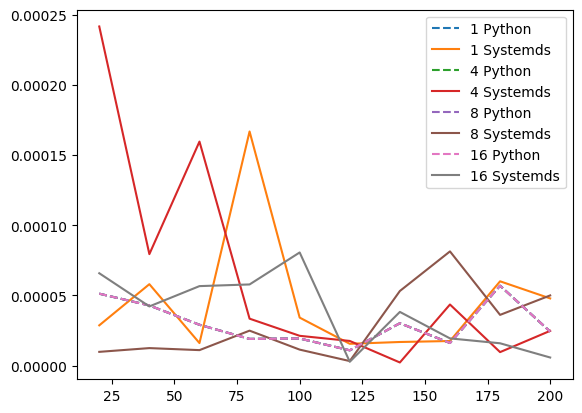

In [14]:
adult_convergence=data_convergence[data_convergence.exp_type=='census_l2svm'].sort_values(by=['total'])
 #.mse_systemds_large.plot())
for i in [1,4,8,16]:#range(0,21,4):
    if i==0: i=1
    plt.plot(adult_convergence[adult_convergence.permutations==i].samples, (adult_convergence[adult_convergence.permutations==i].mse_python_large), label=f'{i} Python', linestyle='--')
    plt.plot(adult_convergence[adult_convergence.permutations==i].samples, (adult_convergence[adult_convergence.permutations==i].mse_systemds_large), label=f'{i} Systemds')
#plt.ylim(,0)
plt.legend()

<Axes: xlabel='permutations', ylabel='mse_systemds_linear'>

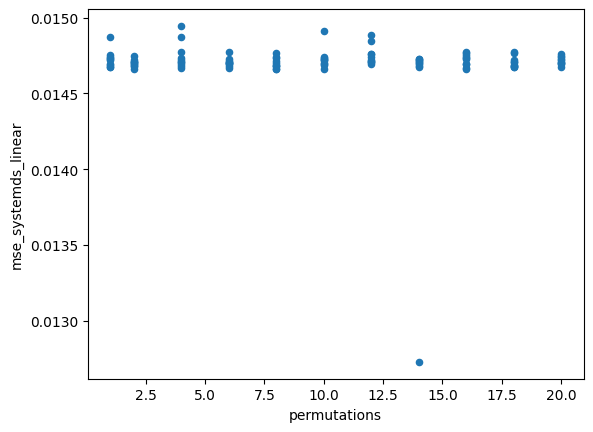

In [15]:
adult_convergence.drop(columns=['exp_type']).plot.scatter(x='permutations',y='mse_systemds_linear')

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


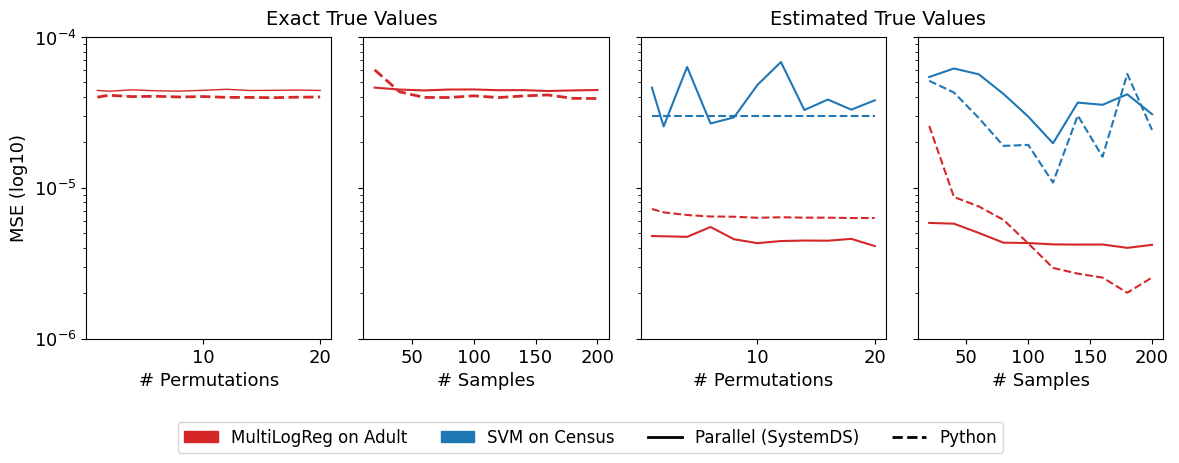

In [17]:
font = {'size' : 13}

matplotlib.rc('font', **font)

# Create a figures and subplots
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,4), sharey='row')



d_adult = data_convergence[data_convergence.exp_type=='adult_linlogreg'].sort_values(by=['total']).drop(columns=['exp_type'])
d_census = data_convergence[data_convergence.exp_type=='census_l2svm'].sort_values(by=['total']).drop(columns=['exp_type'])

def my_scale(data):
    return (data)

sysds_line='-'
sysds_lw=1
sysds_alpha=1

python_line='--'
python_alpha=1
python_lw=2




#convergence to linear
avg_mse_systemds = d_adult.mse_systemds_linear.mean()
avg_mse_python = d_adult.mse_python_linear.mean()
ax1.plot(my_scale(d_adult[d_adult.samples > 100].groupby('permutations').mean().mse_systemds_linear), label=f"Systemds\n(MSE: {avg_mse_systemds:.1e})", color="tab:red", linestyle=sysds_line, linewidth=sysds_lw, alpha=sysds_alpha)
ax1.plot(my_scale(d_adult[d_adult.samples > 100].groupby('permutations').mean().mse_python_linear), label=f"Python\n(MSE: {avg_mse_python:.1e})", color="tab:red", linestyle=python_line, alpha=python_alpha, linewidth=python_lw)


#ax1.plot(my_scale(d_census.groupby('permutations').mean().mse_systemds_linear), label="Systemds (Census)", color="tab:red", linestyle=sysds_line, linewidth=sysds_lw, alpha=sysds_alpha)
#ax1.plot(my_scale(d_census.groupby('permutations').mean().mse_python_linear), label="Python (Census)", color="tab:red", linestyle=python_line, linewidth=python_lw)
#axs[0, 0].set_xlabel("# Permutations")
#axs[0, 0].set_ylabel("MSE")



ax2.plot(my_scale(d_adult[d_adult.permutations > 5].groupby('samples').mean().mse_systemds_linear), color="tab:red", linestyle=sysds_line, alpha=sysds_alpha)
ax2.plot(my_scale(d_adult[d_adult.permutations > 5].groupby('samples').mean().mse_python_linear),  color="tab:red", linestyle=python_line, linewidth=python_lw)

#ax2.plot(my_scale(d_census.groupby('samples').mean().mse_systemds_linear),  color="tab:red", linestyle=sysds_line, alpha=sysds_alpha)
#ax2.plot(my_scale(d_census.groupby('samples').mean().mse_python_linear), color="tab:red", linestyle=python_line, linewidth=python_lw)
#axs[0, 1].set_xlabel("# Samples")
ax1.set_ylabel("MSE (log10)")
ax1.set_yscale('log', base=10)
ax1.set_ylim(0.000001,0.0001)

ax1.set_xlabel("# Permutations")
ax2.set_xlabel("# Samples")






#################
#convergence to PermutationExplainer 1000 samples 50 permutations
#fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(5,3), sharey='row')
ax3.plot(my_scale(d_adult.groupby('permutations').mean().mse_python_large),  color="tab:red", linestyle=python_line)
ax3.plot(my_scale(d_adult.groupby('permutations').mean().mse_systemds_large),  color="tab:red", linestyle=sysds_line)

ax3.plot(my_scale(d_census.groupby('permutations').mean().mse_python_large),  color="tab:blue", linestyle=python_line)
ax3.plot(my_scale(d_census.groupby('permutations').mean().mse_systemds_large),  color="tab:blue", linestyle=sysds_line)
ax3.set_xlabel("# Permutations")



ax4.plot(my_scale(d_adult.groupby('samples').mean().mse_python_large),  color="tab:red", linestyle=python_line)
ax4.plot(my_scale(d_adult.groupby('samples').mean().mse_systemds_large), color="tab:red", linestyle=sysds_line)

ax4.plot(my_scale(d_census.groupby('samples').mean().mse_python_large), color="tab:blue", linestyle=python_line)
ax4.plot(my_scale(d_census.groupby('samples').mean().mse_systemds_large), color="tab:blue", linestyle=sysds_line)
ax4.set_xlabel("# Samples")
ax3.set_yscale('log', base=10)
#ax3.set_ylim(0.0000005,0.0001)

# Add a text box
props = dict(boxstyle='round', facecolor='white', edgecolor='none')

# Place the text box at a specific position
fig1.text(0.23, 1.0, 'Exact True Values', fontsize=14,
        verticalalignment='top', bbox=props)

# Place the text box at a specific position
fig1.text(0.65, 1.0, 'Estimated True Values', fontsize=14,
          verticalalignment='top', bbox=props)


# Custom legend handles and labels
custom_handles = [
    matplotlib.patches.Patch(color='tab:red', label='MultiLogReg on Adult'),
    matplotlib.patches.Patch(color='tab:blue', label='SVM on Census'),
    matplotlib.lines.Line2D([0], [0], color='black', linestyle=sysds_line, lw=2, label='Parallel (SystemDS)'),
    matplotlib.lines.Line2D([0], [0], color='black', linestyle=python_line, lw=2, label='Python'),
]

fig1.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.01), handles=custom_handles, prop={'size': 12})
#fig1.suptitle("Error for Logistic Regression Adult Dataset")
fig1.savefig("../data/runtimes/convergence_wide.pdf", bbox_inches='tight')
fig1.tight_layout()
fig1.show()




============= ADULT ============
Shap values metrics:
Max: 0.67 Mean: 0.01
=== MSE ===
sysds - exact: 4.45e-05
sysds - large: 4.30e-06
python - exact: 4.08e-05
python - large: 4.27e-06
sysds - python: 7.76e-06
============= CENSUS ============
Shap values metrics:
Max: 0.73 Mean: 0.03
=== MSE ===
sysds - large 2.96e-05
python - large 1.92e-05


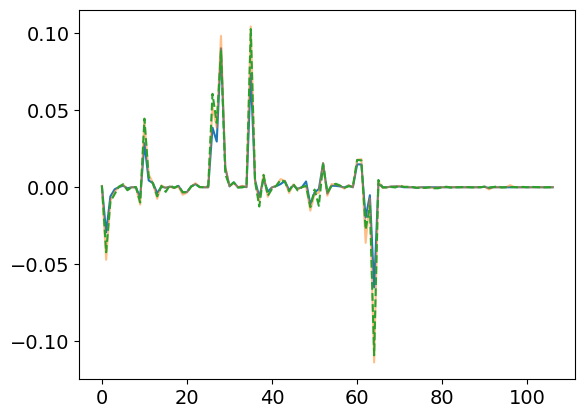

In [30]:
# dataset metrics
d_adult = data_convergence[data_convergence.exp_type=='adult_linlogreg'].sort_values(by=['total']).drop(columns=['exp_type'])
d_census = data_convergence[data_convergence.exp_type=='census_l2svm'].sort_values(by=['total']).drop(columns=['exp_type'])

adult_sysds_vals, adult_python_vals = load_vals(10, 100, 'adult_linlogreg', 10)
census_sysds_vals, census_python_vals = load_vals(10, 100, 'census_l2svm', 10)

plt.plot((shap_vals[1]))
plt.plot(python_vals[1], alpha=.5)
plt.plot(sysds_vals[1],linestyle='--')
print('============= ADULT ============')
print('Shap values metrics:')
print(f'Max: {abs(adult_sysds_vals).max():.2f} Mean: {abs(adult_sysds_vals).mean():.2f}')
print('=== MSE ===')
print(f'sysds - exact: {d_adult[d_adult.samples == 100].mse_systemds_linear.mean():.2e}')
print(f'sysds - large: {d_adult[d_adult.samples == 100].mse_systemds_large.mean():.2e}')
print(f'python - exact: {d_adult[d_adult.samples == 100].mse_python_linear.mean():.2e}')
print(f'python - large: {d_adult[d_adult.samples == 100].mse_python_large.mean():.2e}')
print(f'sysds - python: {d_adult[d_adult.samples == 100].mse_systemds_python.mean():.2e}')
print('============= CENSUS ============')
print('Shap values metrics:')
print(f'Max: {abs(census_sysds_vals).max():.2f} Mean: {abs(census_sysds_vals).mean():.2f}')
print('=== MSE ===')
print(f'sysds - large {d_census[d_census.samples == 100].mse_systemds_large.mean():.2e}')
print(f'python - large {d_census[d_census.samples == 100].mse_python_large.mean():.2e}')

# Examplatory Study

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


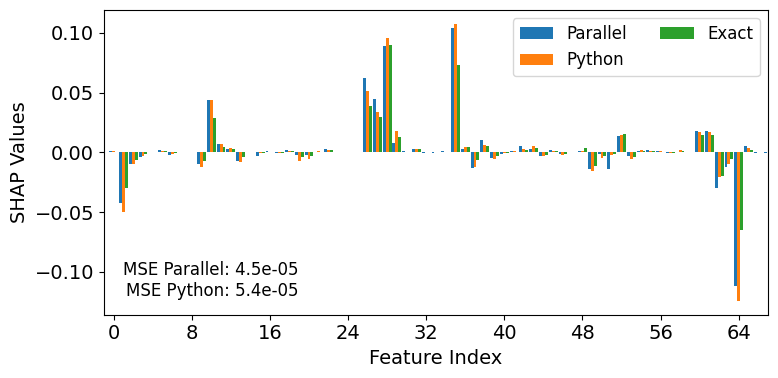

In [23]:
font = {'size' : 14}

matplotlib.rc('font', **font)

#load data
adult_sysds_vals, adult_python_vals = load_vals(10, 100, 'adult_linlogreg', 10)

#t_adult_large = np.genfromtxt('../data/values/shap-values_permutation_large_adult_linlogreg_python.csv', delimiter=',', skip_header=1)[0]
t_adult_exact = np.genfromtxt('../data/values/shap-values_permutation_linear_adult.csv', delimiter=',', skip_header=1)[1]
t_adult_sysds = adult_sysds_vals[1]
t_adult_python = adult_python_vals[1]



# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(8, 4))


# Define the positions of the bars
bar_width = 0.3
index = np.arange(len(t_adult_sysds))
ax1.bar(index - bar_width, t_adult_sysds, bar_width, label='Parallel')

ax1.bar(index, t_adult_python, bar_width, label='Python')

ax1.bar(index+bar_width, t_adult_exact, bar_width, label='Exact')
# Reduce the number of y-ticks
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=10))

#text for mse
mse_sysds = np.mean((t_adult_sysds - t_adult_exact) ** 2)
mse_python = np.mean((t_adult_python - t_adult_exact) ** 2)
ax1.text(1, -0.12, f'MSE Parallel: {mse_sysds:.1e}\nMSE Python: {mse_python:.1e}',multialignment='right', fontsize=12)

#limits
ax1.set_xlim(-1,67)

# Set labels and title
ax1.set_xlabel('Feature Index')
ax1.set_ylabel('SHAP Values')
ax1.legend(ncol=2, prop={'size': 12})


# Show the plot
fig.tight_layout()
fig.savefig("../data/runtimes/accuracy_example_adult.pdf", bbox_inches='tight')
fig.show()

In [24]:
adult_partitions = np.genfromtxt("../data/adult/Adult_partitions.csv", delimiter=',')
#generate partitioned results from shap package
def getPartitionedResults(shap_values, partitions=adult_partitions):
    tmp_partitioned_results = shap_values.copy()
    for i in range(len(partitions[0])):
        start = int(partitions[0][i])-1
        end   = int(partitions[1][i])-1
        #print("s "+str(start)+" e "+str(end))
        #print((shap_vals_permutation[..., 1].values[0][start:end+1]))
        tmp_partitioned_results[start] = sum(shap_values[start:end + 1])
        tmp_partitioned_results[start + 1:end + 1] = 0

    return tmp_partitioned_results

In [25]:
#prep partitioned data
data_partitioned_sysds = np.transpose(np.genfromtxt("../data/adult/shap-values_permutation_3perm_100samples_partitions_50.csv", delimiter=','))[1]
data_partitioned_python = getPartitionedResults(adult_python_vals[1])
data_partitioned_exact = getPartitionedResults(np.genfromtxt('../data/values/shap-values_permutation_linear_adult.csv', delimiter=',', skip_header=1)[1])

data_partitioned = pd.DataFrame({'sysds': data_partitioned_sysds, 'python': data_partitioned_python, 'exact': data_partitioned_exact})
data_partitioned = data_partitioned.loc[data_partitioned.sysds != 0]

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


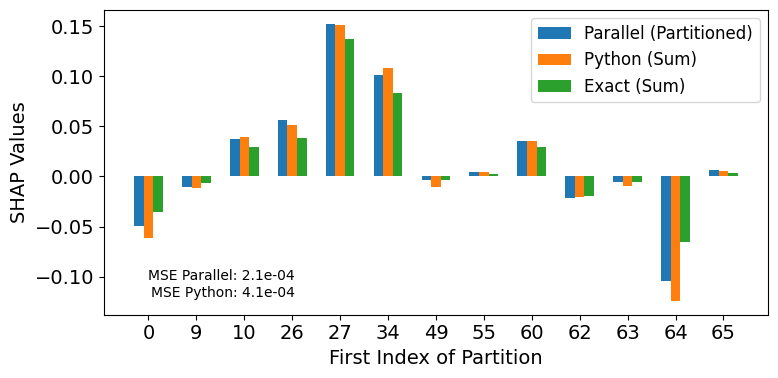

In [27]:
font = {'size' : 14}

matplotlib.rc('font', **font)



# Create a figure and a single subplot
fig, ax2 = plt.subplots(figsize=(8, 4))

# Define the positions of the bars
bar_width = 0.2
index = np.arange(len(data_partitioned))
# Plot bars for the first implementation
ax2.bar(index - bar_width, data_partitioned.sysds, bar_width, label='Parallel (Partitioned)')


# Plot bars for the third implementation
ax2.bar(index, data_partitioned.python, bar_width, label='Python (Sum)')

# Plot bars for the second implementation
ax2.bar(index+bar_width, data_partitioned.exact, bar_width, label='Exact (Sum)')

#text for mse
mse_sysds = np.mean((data_partitioned.sysds - data_partitioned.exact) ** 2)
mse_python = np.mean((data_partitioned.python - data_partitioned.exact) ** 2)
ax2.text(0, -0.12, f'MSE Parallel: {mse_sysds:.1e}\nMSE Python: {mse_python:.1e}',multialignment='right', fontsize=10)


#ax.set_xlim(-1,65)
#ax2.yaxis.set_tick_params(labelleft=False)
#ticks
ax2.set_xticks(index)
ax2.set_xticklabels(data_partitioned.index)
# Reduce the number of y-ticks
#ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=9))

# Set labels and title
ax2.set_xlabel('First Index of Partition')
ax2.set_ylabel('SHAP Values')
#ax.set_title('Comparison of SHAP Values for Different Implementations')
ax2.legend(ncol=1, prop={'size': 12}, loc='upper right')
#fig.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.01), prop={'size': 12})
# Show the plot
fig.tight_layout()
fig.savefig("../data/runtimes/accuracy_example_adult_partitions.pdf", bbox_inches='tight')
fig.show()

# Appendix Plots

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


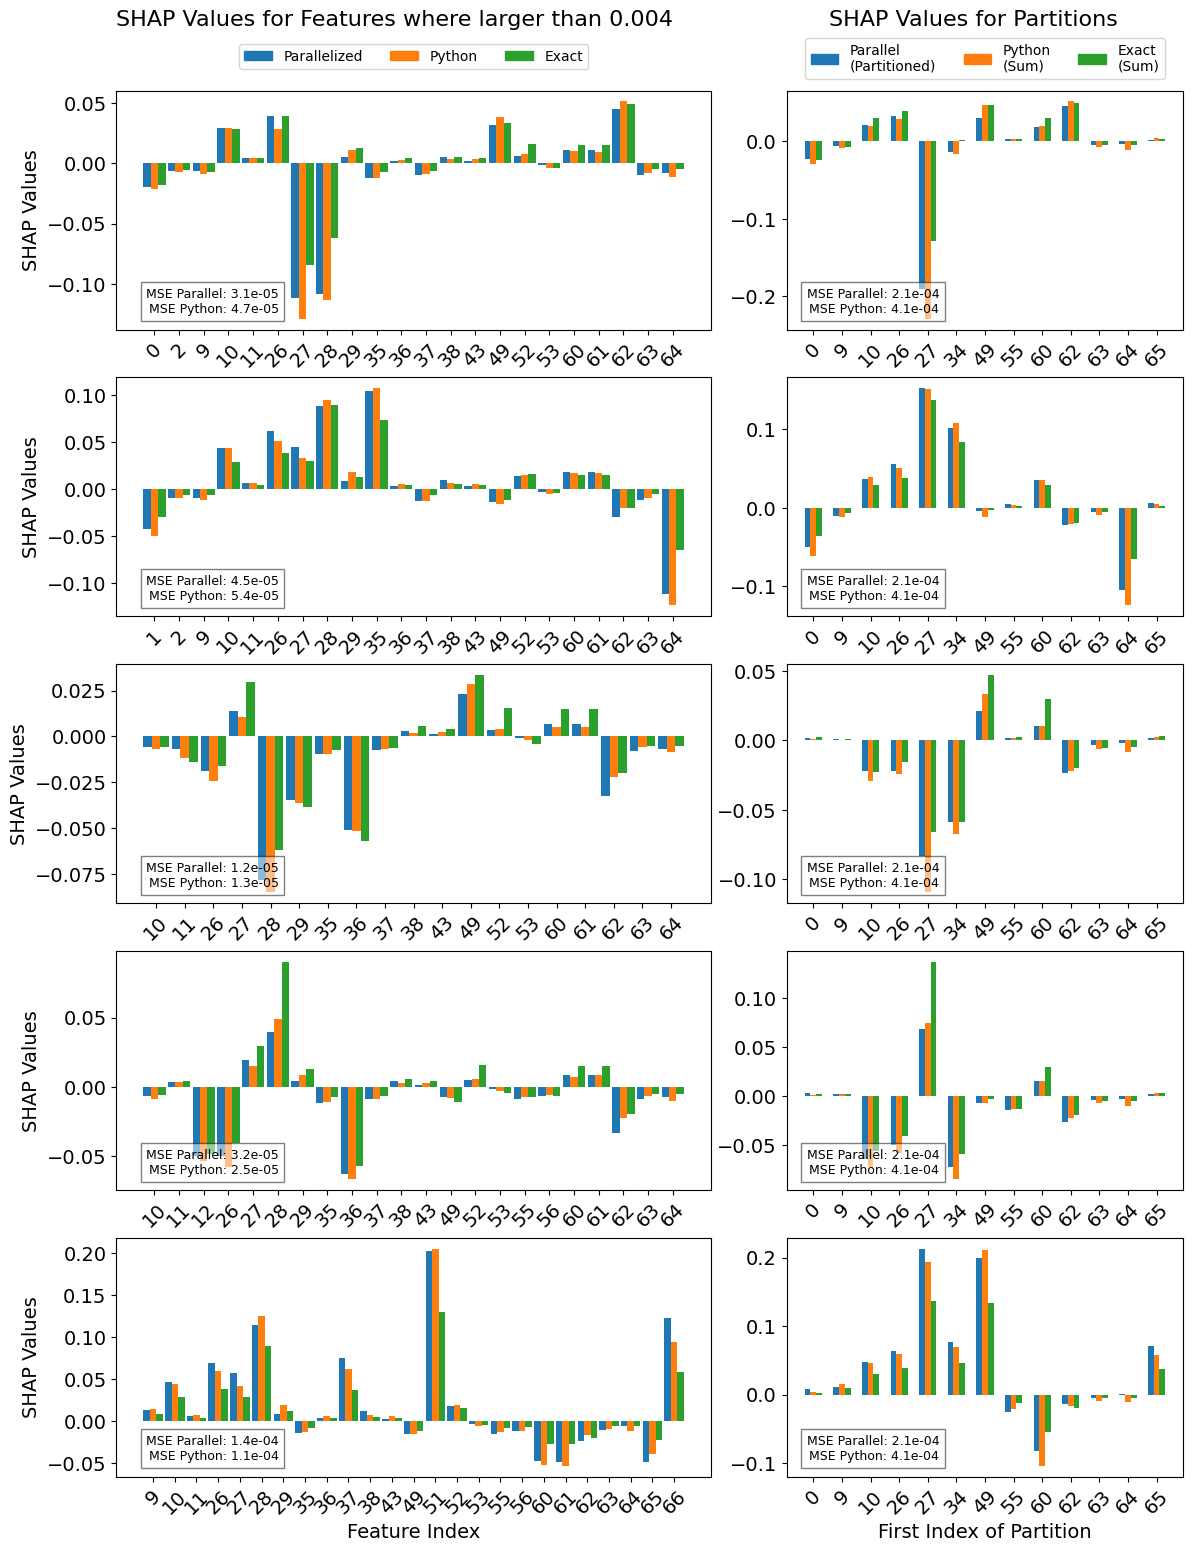

In [28]:
#more examples

adult_linear_vals = np.genfromtxt('../data/values/shap-values_permutation_linear_adult.csv', delimiter=',', skip_header=1)
adult_sysds_partitioned_vals = np.transpose(np.genfromtxt("../data/adult/shap-values_permutation_3perm_100samples_partitions_50.csv", delimiter=','))
n_inst=5

fig1 = plt.figure(figsize=(15,18))
gs = matplotlib.gridspec.GridSpec(n_inst, 3, width_ratios=[3, 2, 0.1])

for i, (t_adult_exact,t_adult_sysds,t_adult_python) in enumerate(zip(adult_linear_vals[:n_inst], adult_sysds_vals[:n_inst], adult_python_vals[:n_inst])):
    
    #full vals
    ax_full = fig1.add_subplot(gs[i, 0])

    #filter significants based on large
    t_grouped = pd.DataFrame({
        'sysds': t_adult_sysds,
        'python': t_adult_python,
        'exact': t_adult_exact
    })
    shap_threshold=0.004
    t_grouped = t_grouped.loc[abs(t_grouped.exact) >= shap_threshold]
    
    
    # Define the positions of the bars
    bar_width = 0.3
    index = np.arange(len(t_grouped))
    ax_full.bar(index - bar_width, t_grouped.sysds, bar_width, label='Parallel')
    ax_full.bar(index, t_grouped.python, bar_width, label='Python')
    ax_full.bar(index+bar_width, t_grouped.exact, bar_width, label='Exact')
    # Reduce the number of y-ticks
    ax_full.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=10))
    #text for mse
    mse_sysds = np.mean((t_adult_sysds - t_adult_exact) ** 2)
    mse_python = np.mean((t_adult_python - t_adult_exact) ** 2)
    ax_full.text(.05, .07, f'MSE Parallel: {mse_sysds:.1e}\nMSE Python: {mse_python:.1e}',multialignment='right', fontsize=9, transform=ax_full.transAxes, bbox=dict(facecolor='white', alpha=0.5))
    #limits
    #ax_full.set_xlim(-1,67)
    #ax_full.set_ylim(-0.2,0.3)
    # Set labels and title
    #ax_full.set_xlabel('Feature Index')
    ax_full.set_ylabel('SHAP Values')

    ax_full.set_xticks(index)
    ax_full.set_xticklabels(t_grouped.index)

    # Rotate x-axis tick labels to prevent overlapping
    for tick in ax_full.get_xticklabels():
        tick.set_rotation(45)
        tick.set_verticalalignment('top')
        #tick.set_y(-0.1)  # Adjust vertical position
    
    
    
    #partitioned vals
    ax_part = fig1.add_subplot(gs[i, 1])
    #partition data
    t_partitioned = pd.DataFrame({
        'sysds': adult_sysds_partitioned_vals[i], 
        'python': getPartitionedResults(t_adult_python), 
        'exact': getPartitionedResults(t_adult_exact)
    })
    t_partitioned = t_partitioned.loc[t_partitioned.sysds != 0]
    
    
    # Define the positions of the bars
    bar_width = 0.2
    index = np.arange(len(data_partitioned))
    # Plot bars for the first implementation
    ax_part.bar(index - bar_width, t_partitioned.sysds, bar_width, label='Parallel\n(Partitioned)')
    
    
    # Plot bars for the third implementation
    ax_part.bar(index, t_partitioned.python, bar_width, label='Python\n(Sum)')
    
    # Plot bars for the second implementation
    ax_part.bar(index+bar_width, t_partitioned.exact, bar_width, label='Exact\n(Sum)')
    
    #text for mse
    mse_sysds = np.mean((data_partitioned.sysds - data_partitioned.exact) ** 2)
    mse_python = np.mean((data_partitioned.python - data_partitioned.exact) ** 2)
    ax_part.text(.05, .07, f'MSE Parallel: {mse_sysds:.1e}\nMSE Python: {mse_python:.1e}',multialignment='right', fontsize=9, transform=ax_part.transAxes, bbox=dict(facecolor='white', alpha=0.5))
    
    
    #ax.set_xlim(-1,65)
    #ax2.yaxis.set_tick_params(labelleft=False)
    #ticks
    ax_part.set_xticks(index)
    ax_part.set_xticklabels(data_partitioned.index)
    # Reduce the number of y-ticks
    #ax_part.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=9))

    # Rotate x-axis tick labels to prevent overlapping
    for tick in ax_part.get_xticklabels():
        tick.set_rotation(45)
        tick.set_verticalalignment('top')
    
    # Set labels and title
    if i == n_inst-1:
        ax_full.set_xlabel('Feature Index')
        ax_part.set_xlabel('First Index of Partition')
        
    if i == 0:
        custom_handles = [
            matplotlib.patches.Patch(color='tab:blue', label='Parallelized'),
            matplotlib.patches.Patch(color='tab:orange', label='Python'),
            matplotlib.patches.Patch(color='tab:green', label='Exact'),
        ]
        ax_full.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.225), handles=custom_handles, prop={'size': 10})
        custom_handles = [
            matplotlib.patches.Patch(color='tab:blue', label='Parallel\n(Partitioned)'),
            matplotlib.patches.Patch(color='tab:orange', label='Python\n(Sum)'),
            matplotlib.patches.Patch(color='tab:green', label='Exact\n(Sum)'),
        ]
        ax_part.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.25), handles=custom_handles, prop={'size': 10})

    # Add a text box
    props = dict(boxstyle='round', facecolor='white', edgecolor='none')
fig1.text(0.125, .925, f'SHAP Values for Features where larger than {shap_threshold}', fontsize=16,
          verticalalignment='top', bbox=props)
fig1.text(0.6, .925, 'SHAP Values for Partitions', fontsize=16,
          verticalalignment='top', bbox=props)

fig1.subplots_adjust(wspace=0.225)
fig1.show()
fig1.savefig("../data/runtimes/accuracy_example_adult_annex.pdf", bbox_inches='tight')

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


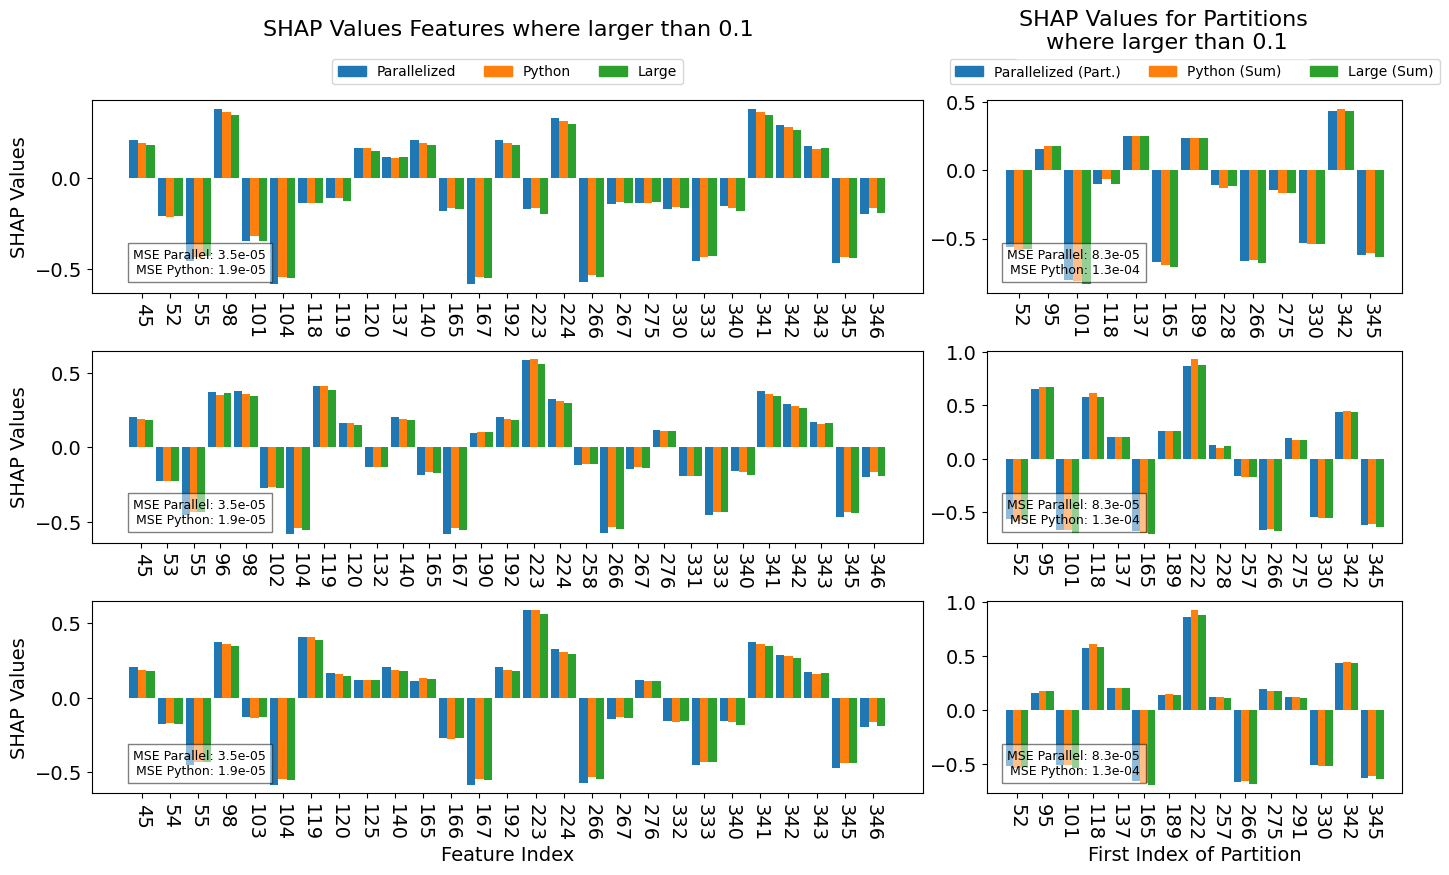

In [31]:

census_sysds_partitioned_vals = np.transpose(np.genfromtxt("../data/census/shap-values_permutation_3perm_100samples_partitions_50.csv", delimiter=','))
census_partitions = np.genfromtxt("../data/census/census_dummycoding_partitions.csv", delimiter=',')
n_inst=3

fig1 = plt.figure(figsize=(18,9))
gs = matplotlib.gridspec.GridSpec(n_inst, 3, width_ratios=[4, 2, 0.1])

for i, (t_adult_exact,t_adult_sysds,t_adult_python) in enumerate(zip(census_vals_large[:n_inst], census_sysds_vals[:n_inst], census_python_vals[:n_inst])):

    #full vals
    ax_full = fig1.add_subplot(gs[i, 0])
    
    #filter significants based on large
    t_grouped = pd.DataFrame({
        'sysds': t_adult_sysds,
        'python': t_adult_python,
        'exact': t_adult_exact
    })
    shap_threshold=0.1
    t_grouped = t_grouped.loc[abs(t_grouped.exact) >= shap_threshold]
    
    # Define the positions of the bars
    bar_width = 0.3
    index = np.arange(len(t_grouped))
    
    ax_full.bar(index - bar_width, t_grouped.sysds, bar_width, label='Parallel')
    ax_full.bar(index, t_grouped.python, bar_width, label='Python')
    ax_full.bar(index+bar_width, t_grouped.exact, bar_width, label='Exact')
    # Reduce the number of y-ticks
    #ax_full.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=10))
    #text for mse
    mse_sysds = np.mean((t_adult_sysds - t_adult_exact) ** 2)
    mse_python = np.mean((t_adult_python - t_adult_exact) ** 2)
    ax_full.text(.05, .1, f'MSE Parallel: {mse_sysds:.1e}\nMSE Python: {mse_python:.1e}',multialignment='right', fontsize=9, transform=ax_full.transAxes, bbox=dict(facecolor='white', alpha=0.5))

    ax_full.set_xticks(index)
    ax_full.set_xticklabels(t_grouped.index)
    
    #limits
    #ax_full.set_xlim(-1,150)
    #ax_full.set_ylim(-0.2,0.3)
    # Set labels and title
    #ax_full.set_xlabel('Feature Index')
    ax_full.set_ylabel('SHAP Values')
    #ax_full.yaxis.label.set_rotation(-90)
    # Rotate x-axis tick labels to prevent overlapping
    for tick in ax_full.get_xticklabels():
        tick.set_rotation(-90)
        tick.set_verticalalignment('top')
        #tick.set_y(-0.1)  # Adjust vertical position





    #partitioned vals
    ax_part = fig1.add_subplot(gs[i, 1])
    #partition data
    t_partitioned_all = pd.DataFrame({
        'sysds': census_sysds_partitioned_vals[i],
        'python': getPartitionedResults(t_adult_python, census_partitions),
        'exact': getPartitionedResults(t_adult_exact, census_partitions)
    })
    t_partitioned_all = t_partitioned_all[t_partitioned_all.sysds!=0]
    t_partitioned = t_partitioned_all.loc[abs(t_partitioned_all.sysds) >= shap_threshold]


    # Define the positions of the bars
    bar_width = 0.3
    index = np.arange(len(t_partitioned))
    # Plot bars for the first implementation
    ax_part.bar(index - bar_width, t_partitioned.sysds, bar_width, label='Parallel (Partitioned)')


    # Plot bars for the third implementation
    ax_part.bar(index, t_partitioned.python, bar_width, label='Python (Sum)')

    # Plot bars for the second implementation
    ax_part.bar(index+bar_width, t_partitioned.exact, bar_width, label='Exact (Sum)')

    #text for mse
    mse_sysds = np.mean((t_partitioned_all.sysds - t_partitioned_all.exact) ** 2)
    mse_python = np.mean((t_partitioned_all.python - t_partitioned_all.exact) ** 2)
    ax_part.text(.05, .1, f'MSE Parallel: {mse_sysds:.1e}\nMSE Python: {mse_python:.1e}',multialignment='right', fontsize=9, transform=ax_part.transAxes, bbox=dict(facecolor='white', alpha=0.5))


    #ax.set_xlim(-1,65)
    #ax2.yaxis.set_tick_params(labelleft=False)
    #ticks
    ax_part.set_xticks(index)
    ax_part.set_xticklabels(t_partitioned.index)
    # Reduce the number of y-ticks
    #ax_part.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=60))

    # Rotate x-axis tick labels to prevent overlapping
    for tick in ax_part.get_xticklabels():
        tick.set_rotation(-90)
        tick.set_verticalalignment('top')
        #tick.set_y(-0.1)  # Adjust vertical position

    # Set labels and title
    if i == n_inst-1:
        ax_full.set_xlabel('Feature Index')
        ax_part.set_xlabel('First Index of Partition')

    if i == 0:
        custom_handles = [
            matplotlib.patches.Patch(color='tab:blue', label='Parallelized'),
            matplotlib.patches.Patch(color='tab:orange', label='Python'),
            matplotlib.patches.Patch(color='tab:green', label='Large'),
        ]
        ax_full.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.25), handles=custom_handles, prop={'size': 10})
        custom_handles = [
            matplotlib.patches.Patch(color='tab:blue', label='Parallelized (Part.)'),
            matplotlib.patches.Patch(color='tab:orange', label='Python (Sum)'),
            matplotlib.patches.Patch(color='tab:green', label='Large (Sum)'),
        ]
        ax_part.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.25), handles=custom_handles, prop={'size': 10})

# Add a text box
props = dict(boxstyle='round', facecolor='white', edgecolor='none')
fig1.text(0.22, .97, f'SHAP Values Features where larger than {shap_threshold}', fontsize=16,
          verticalalignment='top', bbox=props, multialignment='center')
fig1.text(0.64, .981, f'SHAP Values for Partitions\n where larger than {shap_threshold}', fontsize=16,
          verticalalignment='top', bbox=props, multialignment='center')

fig1.subplots_adjust(wspace=0.15, hspace=.3)
fig1.show()
fig1.savefig("../data/runtimes/accuracy_example_census_annex.pdf", bbox_inches='tight')